## Analiza danych na temat mieszkań z rybku wtórnego na sprzedaż w Warszawie z dnia 20 maja 2024.

Poniższa analiza przedstawia dane na temat rynku wtórnego nieruchomości w Warszawie pod koniec maja 2024 roku. 
Dane te obejmują:
* ceny mieszkań, 
* metraż, 
* liczbę pokoi, 
* lokalizacje (z podziałem na dzielnice)
* rodzaj sprzedawcy. 

Na podstawie tych danych wyciągnięto wnioski odnośnie do cen, zależności między różnymi parametrami, a także cech specyficznych dla ofert mieszkań w  poszczególnych dzielnicach.


Na początku analizy wczytujemy dane oraz kowertujemy odpowiednio kolumny, tak aby późniejsza analiza była przyjemniejsza.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import locale
import plotly.express as px
from plotly.subplots import make_subplots

#ustawienie lokalizacji na polską
try:
    locale.setlocale(locale.LC_ALL, 'pl_PL.UTF-8')
except locale.Error:
    locale.setlocale(locale.LC_ALL, 'pl_PL')

df = pd.read_excel("cleaned_data.xlsx")

#konwersja ceny na liczby zmiennoprzecinkowe z uwzględnieniem formatu waluty
def parse_price(price):
    try:
        return locale.atof(price.replace(' PLN', '')) if isinstance(price, str) else price
    except ValueError:
        return float('nan')

df['Price'] = df['Price'].apply(parse_price)
df['Price per m2'] = df['Price per m2'].apply(parse_price)

#funkcje do formatowania ceny - do osi wykresów
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

#separator kwot na osi
def millions(x, pos):
    'The two args are the value and tick position'
    return '{:,.0f}'.format(x).replace(',', ' ')

print(df.head())


                      Street      Urban area        District     m2  Rooms  \
0                ul. Osowska         Grochów  Praga-Południe  52.30      2   
1  ul. Wacława Sierpińskiego        Rakowiec          Ochota  33.30      1   
2               ul. Dymińska  Stary Żoliborz        Żoliborz  37.00      2   
3               ul. Narwik 8           Górce          Bemowo  58.50      2   
4     ul. Józefa Szanajcy 11      Nowa Praga    Praga-Północ  36.21      2   

   Floor   Price  Price per m2 Currency          Seller type  \
0      2  799000       15277.0      PLN  Biuro nieruchomości   
1      2  670000       20120.0      PLN      Oferta prywatna   
2      4  669000       18081.0      PLN      Oferta prywatna   
3      4  970000       16581.0      PLN      Oferta prywatna   
4      2  720000       19884.0      PLN      Oferta prywatna   

            Estate agency  
0  SZCZĘSNY NIERUCHOMOŚCI  
1                     NaN  
2                     NaN  
3                     NaN  
4     

### Rozkład cen mieszkań

Jako pierwszy czynnik przeazalizujemy rozkład cen mieszkań na ryku wtórnym w Warszawie.
Analiza czynnika cenowego pozwala określić dominujące przedziały cenowe, wykryć trendy cenowe oraz w konsekwencji zrozumieć z jakim budżetewm należy się liczyć w przypadku zakupu mieszkania.

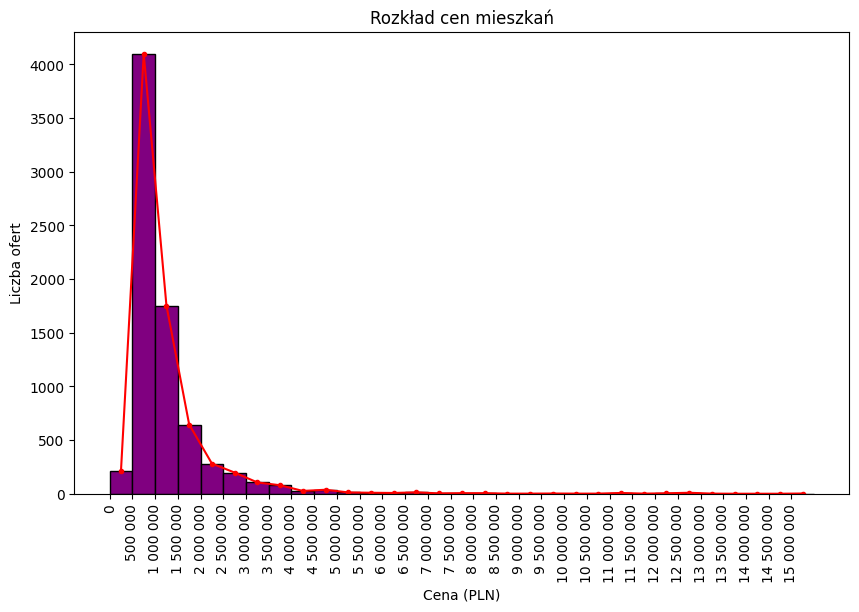

In [36]:
hist, bins = np.histogram(df['Price'], bins=range(0, int(df['Price'].max()) + 500000, 500000))
bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist, width=500000, color='purple', edgecolor='black')
plt.title('Rozkład cen mieszkań')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba ofert')

plt.plot(bin_centers, hist, color='red', linestyle='-', marker='o', markersize=3, label='Lini trendu')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(np.arange(0, max(bins), step=500000), rotation=90)
plt.show()

Na wykresie możemy zauważyć, że najwięcej ofert, bo aż 4100 mieści się w przedziale cenowym 500k - 1M. 
Drugim co do liczby ofert przedziałem cenowym jest ten z cenami pomiędzy 1M i 1.5M, który ma 1753 oferty.
Trzecie i czwarte miejsce wiążą się z jeszcze większymi kosztami, ponieważ jest to odpowiednio "1.5M - 2M", oraz "2M- 2.5M". Dopiero następne, czyli piąte miejsce należy do najniższego przedziału mieszkań "do 500k" z liczbą 216 ofert.

Można wysnuć wniosek, że oferty poniżej 500k nie zdarzają się często, a większość osób zdecydowanych na zakup mieszkania z rynku wtórnego w Warszawie musi się liczyć z kosztami powyżej tej kwoty.

### Zależność ceny od metrażu mieszkania 

Kolejną istotną kwestią, którą zbadamy jest zależność pomiędzy ceną, a metrażem mieszkania.
Poniższa analiza pozwoli nam zrozumieć w jaki sposób cena mieszkania jest zależna od jego powierzchni całkowitej. W praktyce może to dać nam to wskazówkę czy cena konkretnej oferty jest adekwatna do metrażu.

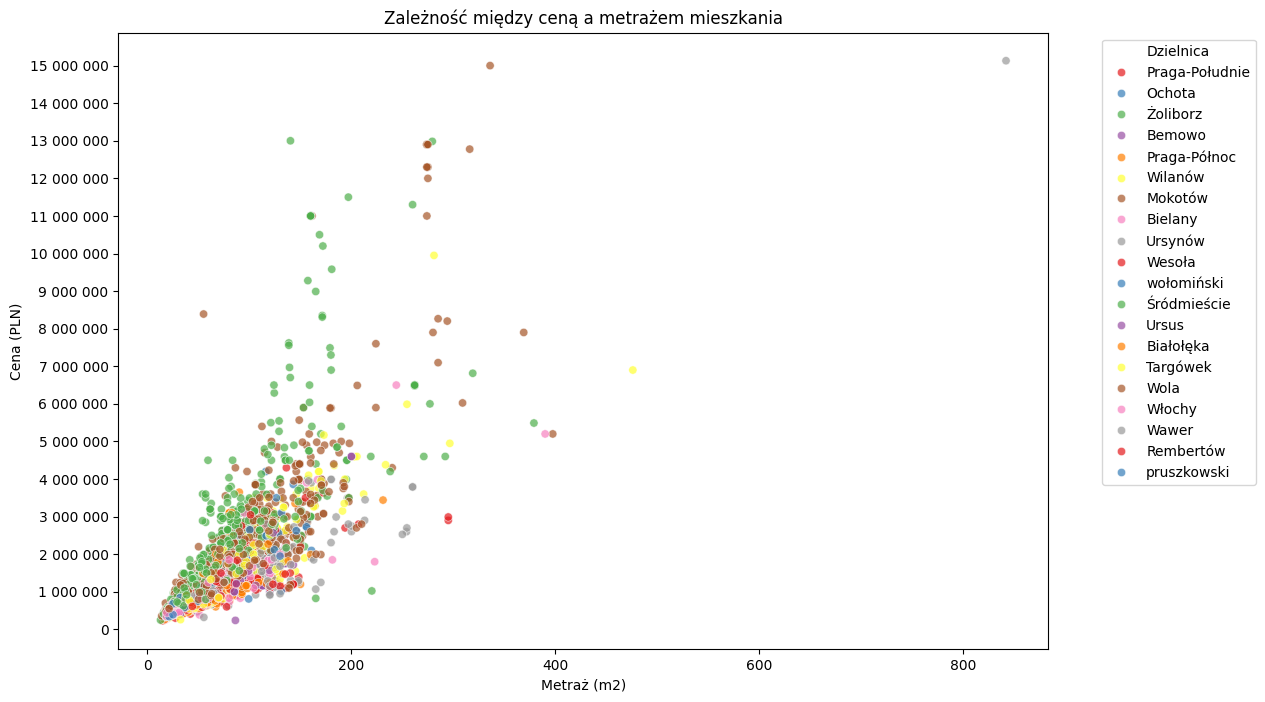

In [17]:
filtered_districts = df[df['District'] != 'Warszawa']
offers_per_district = filtered_districts['District'].value_counts()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='m2', y='Price', data=filtered_districts, hue='District', palette='Set1', alpha=0.7)
plt.title('Zależność między ceną a metrażem mieszkania')
plt.xlabel('Metraż (m2)')
plt.ylabel('Cena (PLN)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1000000))
plt.show()

Na wykresie można zauważyć dodatnią korelacje. Największe zagęszczenie danych mieści sie na metrażu od 40 m2 (kosztowo wychodzi od 460k do 1.23M) do 70 m2 (kosztowo szacuje sie to od 779k do 2.449M).

Ponadto można wysnuć kilka bardzo interesujących wniosków dotyczących mieszkań w poszczególnych dzielnicach.

Zaczynając od najdroższej dzielnicy czyli Śródmieścia, które oferuje mieszkania na sprzedaż w każdym metrażu. Ceny w tej dzielnicy są zdecydowanie najwyższe (zielone kropki wybijające się do góry na wykresie), najwięcej ofert w tej dzielnicy dotyczy mieszkań o powierzchni od 50m2 do 65m2.

Drugą i sąsiednią dzielnicą pod względem wysokiej ceny jest Wola, której przeważająca liczba ofert dotyczy mieszkania w metrażu od 36m2 do 50m2. Na wykresie można zauważyć również, że mieszkania powyżej 65m2 na Woli mają jeden z najwyższych stosunków Cena-Metraż w całej Warszawie. 

Żoliborz standardowo oferuje mieszkania o większych powierzchniach niż inne dzielnice, najwięcej ofert dotyczy metraży pomiędzy 46, a 78m2. Ceny na Żoliborzu są stosunkowo wysokie w porównaniu do większości dzielnic Warszawy.

Kolejną dzielnicą oferującą bardzo duże zróżnicowanie cenowe dla większych metraży (powyżej 75m2) jest Wilanów, na którym w ofertach królują powierzchnie od 41m2 do 57m2.

Następną w kolejności ceny jest dzielnica Mokotów, w której dostępne jest najwięcej ofert, wobec tego na wykresie można zaobserwować duże zróżnicowanie. Najwięcej ofert dotyczy mieszkań od 36m2 do 66m2, jednak należy zaznaczyć, że Mokotów ma nadzwyczaj dużo ofert również mieszkań z metrażem powyżej tego przedziału.

Kolejną sąsiednią dzielnicą do Mokotowa oraz Śródmieścia jest Ochota, i również pod względem cenowym idzie to w parze. W tej dzielnicy najwięcej ofert dotyczy mieszkań pomiędzy 36, a 56 m2. Warto zaznaczyć, że stosunek mieszkań powyżej 50m2 w tej dzielnicy wychodzi mniej korzystnie niż w przypadku mniejszych metraży.

Pierwszą dzielnicą po drugiej stronie Wisły pod względem wysokich cen okazuje się Praga-Północ, której dotyczy stosunkowo mało ofert, jednak najwięcej z nich dotyczy metrażu od 35m2 do 47m2. Na wykresie możemy zobaczyć, że Praga-Północ ma bardzo wysoki stosunek Cena-Metraż dla mieszkań poniżej 33m2.

Kontynuujemy dalej z Pragą, bo następna w kolejce jest Praga-Południe, której w przeciwieństwie do przeciwniczki, dotyczy sporo ofert. Najpopularniejsza powierzchnia mieszkania to od 36 do 60m2.

Na Ursynowie najwięcej ofert dotyczy apartamentów z powierzchnią od 61 do 70 m2.

Włochy cenowo na wykresie układają się tak samo z tym, że ma dwa przedziały,w których można znaleźć najwięcej ofert, są to: od 30 do 39 m2 oraz od 53 do 60m2.

Następne w kolejności spadających cen są Bielany, gdzie na próżno szukać lokali poniżej 34m2, za to najwięcej ofert jest dostępnych dla osób szukających metrażu od 41 do 57m2.

Bemowo już jest statystycznie jedną z tańszych dzielnic, najwięcej ofert tam dotyczy lokali o średniej wielkości tj. od 45 m2 do 60 m2.

Targówek okazał się zaskakująco tani jak na lokalizację oraz fakt, że posiada metro. Wśród ofert mieszkań z ryku wtórnego królują oferty dotyczące mieszkań od 45 do 62m2.

Sytuacja na Białołęce wygląda bardzo podobnie zarówno w przypadku cen, jak i lokali, które najczęściej można znaleźć o powierzchni od 44 m2 do 61 m2.

Zostały do omówienia jeszcze najtańsze, ale i zarazem najdalsze od centrum miasta lokacje:
* Ursus, na którym dominują lokale o powierzchni od 42 do 68 m2
* Wawer, gdzie oferty dotyczą stosunkowo sporych mieszkań, bo od 62 do 85 m2
* Rembertów, przy którym ciężko mówić o "największej ilośći", bo jest to jedynie kilka kropek na wykresie, aczkolwiek najwięcej wartości znajduje sie na 35m2 oraz od 53 do 56 m2
* W Wesołej sytuacja wygląda podobnie, najwięcej ofert dotyczy metrażu pomiędzy 61m2 a 70 m2, ale jest to zbyt mała liczba mieszkań żeby się na tym opierać

Warto zaznaczyć, że poniżej analizowane dane już nie dotyczą bezpośrednich dzielnic Warszawy, a powiatów sąsiadujących. Jednak bez ustawiania filtra o "odległości od wybranej lokalizacji" takie dane również zostały wyświetlone (i pobrane przez nas) dla wyników "Warszawy", wobec tego również podjęłyśmy się ich analizy, a są to:
1. Powiat Wołomiński, gdzie znajdują sie mieszkania oferowane w Ząbkach, sąsiadujących z Warszawą, a konkretnie dzielnicami: Targówek oraz Rembertów. 
Wyników dla tego powiatu nie uzyskałyśmy wiele, jednak ceny plasują się tak jak na Bemowie czy Targówku. Najwięcej ofert dotyczy metrażu ok 50 m2.
2. Powiat Pruszkowski, czyli sąsiadujący z dzielnicami Urysnów oraz Włochy, dotyczy ofert 2 mieszkań, których ceny plasują się jako jedne z najniższych.

### Rozkład cen mieszkań z podziałem na dzielnice

W tym kroku skupimy się na rozkładzie cen z podziałem na dzielnice. Analiza ta pozwoli nam zidentyfikować obszary o bardziej zróżnicowanych poziomach cen. Będzie to cenna informacja dla osób poszukujących mieszkania, gdyż pozwoli im na porównanie cen w różnych dzielnicach i wybór lokalizacji odpowiadającej ich budżetowi.


C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\2044910369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='District', y='Price', data=filtered_districts, palette='coolwarm_r')


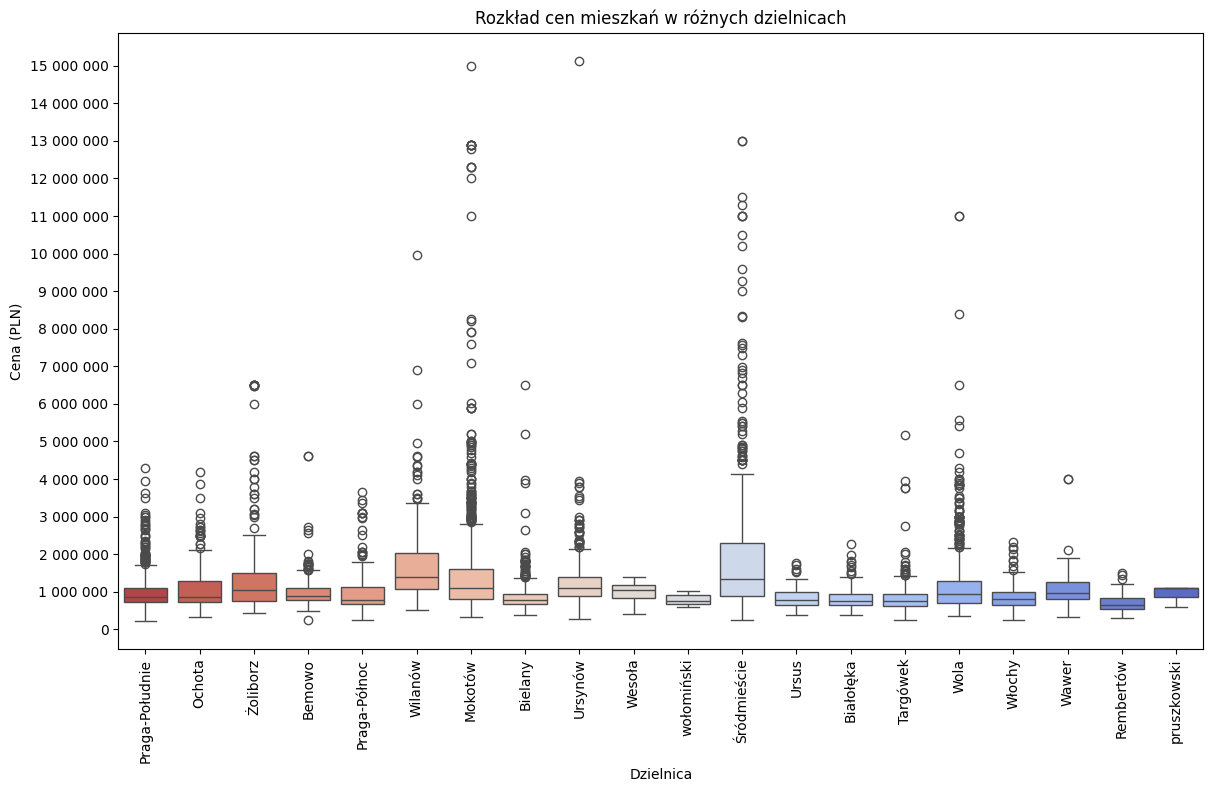

In [4]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='District', y='Price', data=filtered_districts, palette='coolwarm_r')
plt.title('Rozkład cen mieszkań w różnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Cena (PLN)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1000000))
plt.show()

Wykres przedstawia rozkład cen mieszkań w różnych dzielnicach Warszawy. Możemy obserwować duże zróżnicowanie cen, zarówno minimalnych, maksymalnych, jak i mediany. Najdroższe dzielnice to Mokotów, Śródmieście i Wilanów, gdzie ceny potrafią przekraczać 10 milionów złotych. Z drugiej strony, w tańszych i bardziej oddalonych od centrum dzielnicach, jak Rembertów, Ursus czy Wesoła, ceny mieszczą się w przedziale od 300 do 1,5 miliona złotych.

Warto zwrócić uwagę na rozpiętość cen w poszczególnych dzielnicach. W najdroższych dzielnicach, jak Mokotów czy Wilanów, różnica między ceną minimalną a maksymalną jest ogromna. Oznacza to, że w tych dzielnicach można znaleźć zarówno stosunkowo tanie mieszkania, jak i te najdroższe w Warszawie. Warto zwrócić uwagę, że w droższych dzielnicach 1 kwartyl czasem znajduje się powyżej 3 kwartylu z tanich dzielnic, co daje ogromną różnicę cenową. W tańszych dzielnicach rozpiętość cen jest mniejsza, co sugeruje bardziej jednorodny rynek nieruchomości.

Analiza mediany cen w poszczególnych dzielnicach pozwala na porównanie cen typowych mieszkań. W Śródmieściu mediana wynosi 1,33 miliona złotych, na Wilanowie 1.4M, na Targówku, który znajduje się w podobnej odległości od centrum mediana wynosi jedynie 629k. Różnica ta pokazuje, jak znacząco różni się poziom cen w różnych dzielnicach Warszawy.

Przed podjęciem decyzji o zakupie mieszkania w Warszawie, warto dokładnie przeanalizować ceny w różnych dzielnicach i wybrać tę, która najlepiej odpowiada naszym potrzebom i budżetowi.

### Średnia cena za m2 w poszczególnych dzielnicach

Kolejnym krokiem będzie analiza średniej ceny za m2 w poszczególnych dzielnicach. Wykres ten przedstawi średnie wartości cen w różnych lokalizacjach. Pomoże to w szybkim porównaniu cen w różnych dzielnicach i identyfikacji najdroższych i najtańszych obszarów,  a także może pomóc w zorientowaniu się czy znaleziona oferta ma korzystną cenę (jest poniżej średniej).

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\2589900908.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_per_m2.index, y=mean_price_per_m2.values, palette='coolwarm_r')


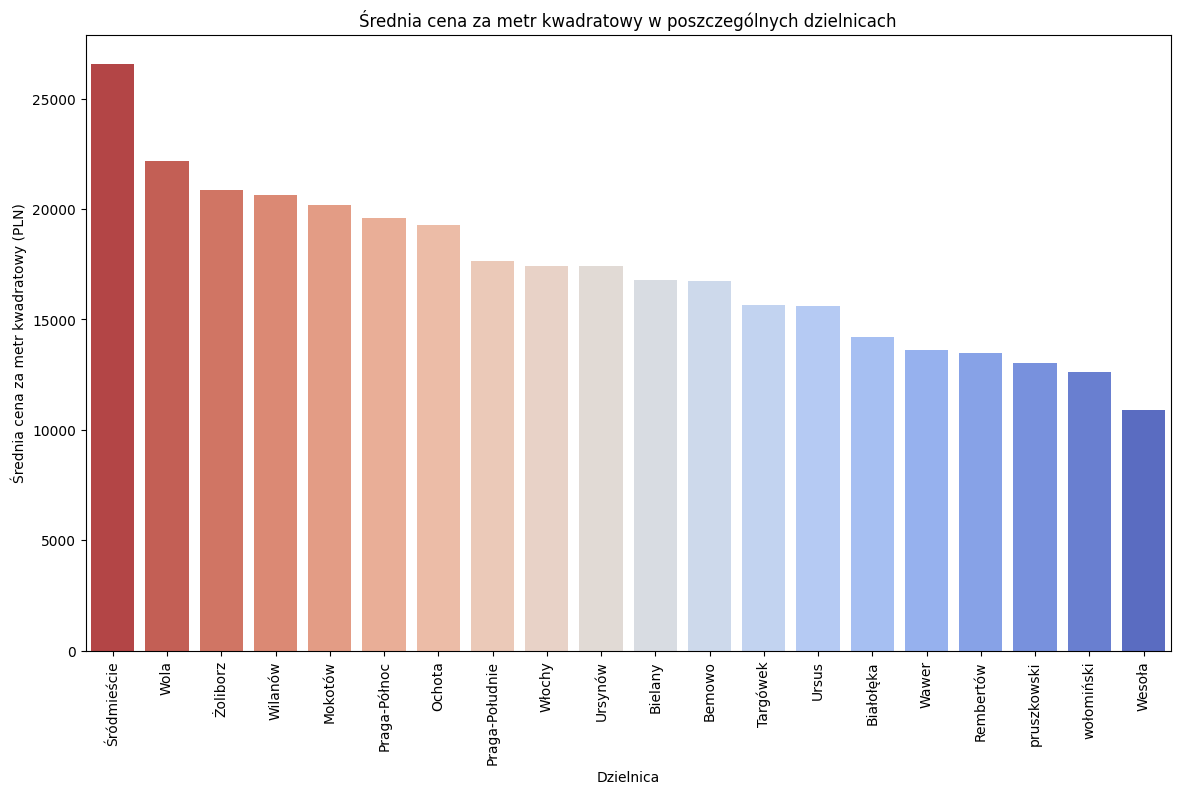

In [5]:
mean_price_per_m2 = filtered_districts.groupby('District')['Price per m2'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=mean_price_per_m2.index, y=mean_price_per_m2.values, palette='coolwarm_r')
plt.title('Średnia cena za metr kwadratowy w poszczególnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Średnia cena za metr kwadratowy (PLN)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5000))
plt.show()


Jak widać na wyjresie rynek nieruchomości w Warszawie charakteryzuje się zróżnicowaniem cenowym w zależności od dzielnicy. Analizując średnie ceny za mkw, możemy wyróżnić kilka stref cenowych:

Jak można było przewidzieć najdroższą dzielnicą okazuje się Śródmieście z zawrotną ceną 25.522 zł/m2. 3 tysiące taniej za m2 trzeba zapłacić na sąsiedniej Woli. Miejsce 3 w rankingu najdroższych dzielnic zajmuje Żoliborz z kwotą 20.850 zł/m2. Z kwotami powyżej 20 tysięcy na kolejnych miejscach plasują się odpowiednio: Wilanów oraz Mokotów.

Nazwijmy to "średnią półką", za kwotę nieco poniżej 20 tysięcy za m2 możena zakupić mieszkanie na Pradze-Północ oraz Ochocie.

Do tańszych dzielnic należą: Praga-Południe ze średnią kwotą 17.645 zł/m2, Włochy oraz Ursynów 200 złotych taniej, Bielany i Bemowo z kwotą ok. 16.750 zł/m2 i jak już mogliśmy wcześniej zauważyć tani Targówek ze średnią 15.649 zł/m2. 

Bardzo tanimi dzielnicami są Ursus, gdzie za 1m2 trzeba średnio dać 15.592 zł/m2. Białołęka jest sporo tańsza, bo wystarczy przygotować 14.199 zł/m2. Po drugiej stronie Wisły z kwotą Wawer oraz Rembertów z kwotą ok. 13.5 zł/m2.

Jeśli chodzi o powiaty sąsiednie to pruszkowski: 13.009 zł/m2, natomiast wołomiński: 12.604 zł, co czyni je najtańszymi w zestawieniu.

### Średni metraż mieszkania w zależności od dzielnicy

Ciekawą kwestią również jest średni metraż mieszkań w poszczególnych dzielnicach. Analiza tego czynnika pozwoli nam na zauważenie różnic pomiędzy średnią wielkością mieszkań w różnych częściach Warszawy.  Informacje te mogą być pomocne dla osób poszukujących mieszkania konkretnej wielkości.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\2033293749.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_area_by_district.values, y=average_area_by_district.index, palette='viridis')


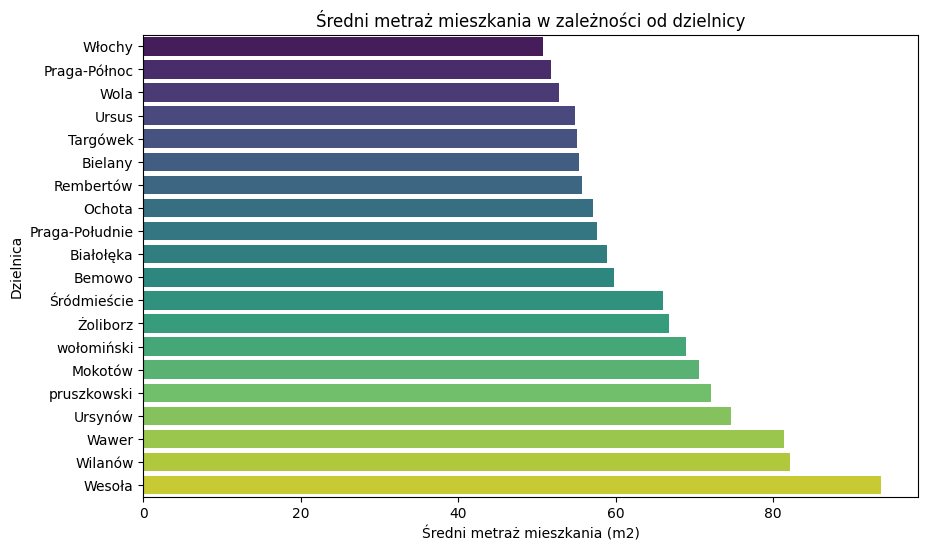

In [20]:
average_area_by_district = df.groupby('District')['m2'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=average_area_by_district.values, y=average_area_by_district.index, palette='viridis')
plt.xlabel('Średni metraż mieszkania (m2)')
plt.ylabel('Dzielnica')
plt.title('Średni metraż mieszkania w zależności od dzielnicy')
plt.show()


Z analizy średniej powierzchnii mieszkania w zależności od dzielnicy możemy wynsuć wniosek, że dzielnice najdalsze od Centrum cechują się njawiększymi metrażami, są to odpowiednio: Wesoła, Wilanów, Wawer, Ursynów. Dodatkowo w tej części rankingu znalazły się też powiaty pruszkowski, wołomiński oraz Mokotów, które charakteryzuje sie dużą ilością różnoronych ofert.

Do dzielnic ze średnią najmneijszą powierzchnią mieszkań zaliczają się: Włochy, Praga-Północ, Wola, Ursus, Targówek i Bielany.

W przypadku najmneijszego średniego metrażu ciężko doszukiwać się przyczyny, ponieważ dzielnice te są bardzo różnorodnie położone i nie widać między tym jawnej zależności. 

### Podział ofert według rodzaju sprzedawcy

Na tym etapie przjrzymy się wystawcom ofert nieruchomości. Wykres ten pokaż nam jaka część ofert pochodzi od osób prywatnych, a jaka od agencji nieruchomości. Informacje te mogą być użyteczne dla osób kupujących ze względu na możliwość negocacji ceny i uwzględnieniu jak dobrze zweryfikowane są konkretne oferty mieszkań.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\3525368534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='viridis_r')


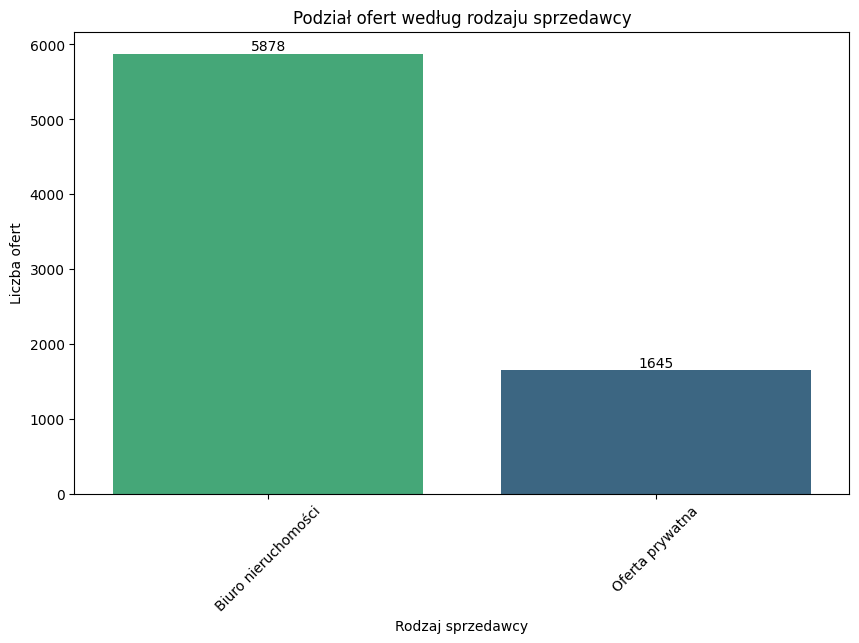

In [6]:
seller_counts = df['Seller type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='viridis_r')
plt.title('Podział ofert według rodzaju sprzedawcy')
plt.xlabel('Rodzaj sprzedawcy')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=45)
for index, value in enumerate(seller_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

Jak możemy zaobeserować na wykresie, biura nieruchomości wystawiają ponad 3-krotnie więcej ofert niż osoby prywatne. 

Może na to wpływać fakt, że osoby sprzedające nie mają odpowiedniej ilości czasu, aby oprowadzać chętnych po nieruchomości i załatwiać wszelkie formalności, ale i również być to spowodowane większym zainteresowaniem tego typu ofert. Oferty wystawiane przez biura nieruchomości są weryfikowane i wyceniane okiem specjalistów, dodatkowo weryfikowane są dokumenty własności, co pozwala uniknąć kupującym ewentualnych problemów.

### Średnia cena mieszkań w zależności od sprzedawcy

Skoro już wiemy, że większością opublikowanych ofert zajmuje się biuro nieruchomości, sprawdźmy zatem jak wpływa to na cenę wystawianych mieszkań. Porównamy teraz średnie ceny oferowane przez osoby prywatne i agencje nieruchomości. Analiza ta może pomóc w określeniu, u kogo można znaleźć tańsze oferty.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\3959640435.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_seller.index, y=mean_price_seller.values, palette='pastel')


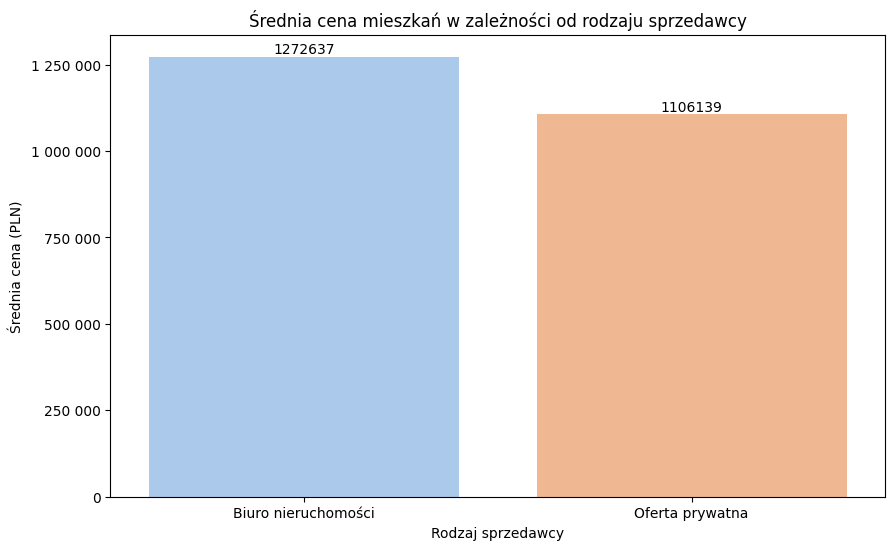

In [7]:
mean_price_seller = df.groupby('Seller type')['Price'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_price_seller.index, y=mean_price_seller.values, palette='pastel')
plt.title('Średnia cena mieszkań w zależności od rodzaju sprzedawcy')
plt.xlabel('Rodzaj sprzedawcy')
plt.ylabel('Średnia cena (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
for index, value in enumerate(mean_price_seller.values):
    plt.text(index, value, str(int(value)), ha='center', va='bottom')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(250000))
plt.show()

Oferty wystawiane przez biura nieruchomości są średnio droższe o 120 tysięcy złotych. 

To oczywiście zrozumiałe, ponieważ oprócz ceny wystawionej nieruchomości organizacje te liczą sobie również % od dokonanych transakcji. 

### Rozkład liczby pokoi.

W tym kroku skupimy się na liczbie pokoi w ofertach mieszkaniowych. Analiza tego wskaźnika pokaże nam jaka jest dominująca liczba pokoi w dostępnych na rynku nieruchomościach. Informacje te są cenne dla klientów posiadających bądź planujących większe rodziny.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\518593902.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




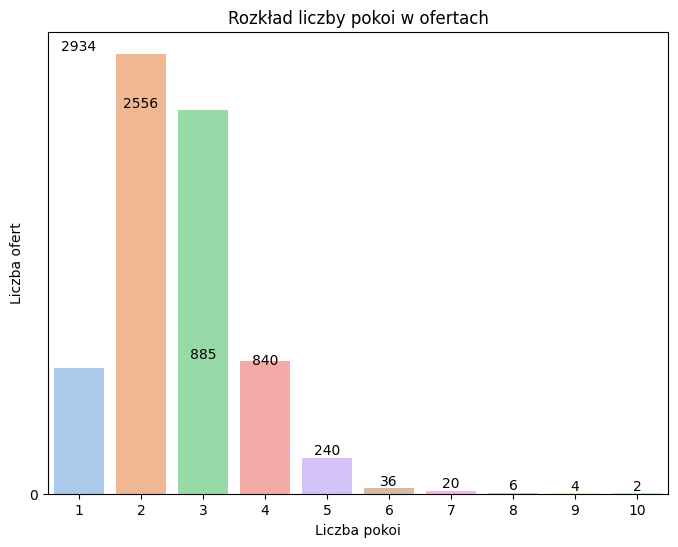

In [47]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Rooms', data=df, palette='pastel')
plt.title('Rozkład liczby pokoi w ofertach')
plt.xlabel('Liczba pokoi')
plt.ylabel('Liczba ofert')
for index, value in enumerate(df['Rooms'].value_counts().values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.gca().set_yticklabels([])
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(250000))
plt.show()

Powyższy wykres ppokazuje, że na warszawskim rynku nieruchomości zdecydowanie dominują mieszkania dwupokojowe i trzypokojowe. Te układy stanowią łącznie ponad 60% wszystkich ofert.

Dwupokojowe mieszkania, których jest aż 2934 są najpopularniejsze ze względu na swoją funkcjonalność i przystępną cenę. Idealnie nadają się dla singli, par lub studentów. Ich przeważnie niewielki metraż ułatwia utrzymanie czystości i pomaga zadbać o prywatność.

Trzypokojowe mieszkania dostępne w ilości 2556 cieszą się dużą popularnością wśród rodzin z małymi dziećmi. Oferują one wystarczającą ilość przestrzeni dla komfortowego życia, zapewniając jednocześnie oddzielne pokoje dla dzieci i rodziców.

Mieszkania z czterema pokojami, których w danych znalazło się 885, stanowią trzecią co do wielkości grupę. Są one często wybierane przez rodziny z większymi dziećmi lub osoby ceniące przestronne wnętrza.

Mieszkania z mniejszą lub większą liczbą pokoi stanowią mniejszość ofert. 

Mieszkania jednopokojowe, których jest 840, są popularne wśród singli lub osób szukających niedrogiego lokum. Z kolei mieszkania z pięcioma pokojami (240) i więcej (36 - 10) są wybierane przez osoby zamożne, potrzebujące dużo przestrzeni lub prowadzące działalność gospodarczą w domu.

Poniżej przeanalizujemy jak liczba pokoi wpływa na na cenę czy metraż ofert.

### Średnia cena mieszkań w zależności od liczby pokoi

A teraz zbadamy jak ilość pokoi w mieszkaniu determinuję cenę nieruchomości. Zależnośc ta pokaże nam czy większa ilość pomieszczeń wiąże się z wyższymi kosztami oraz pomoże oszacować jaki budżet należy odłożyć, jeśli klient posiada szczegółowe wymagania w tej materii.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\519425533.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_rooms.index, y=mean_price_rooms.values, palette='viridis_r')


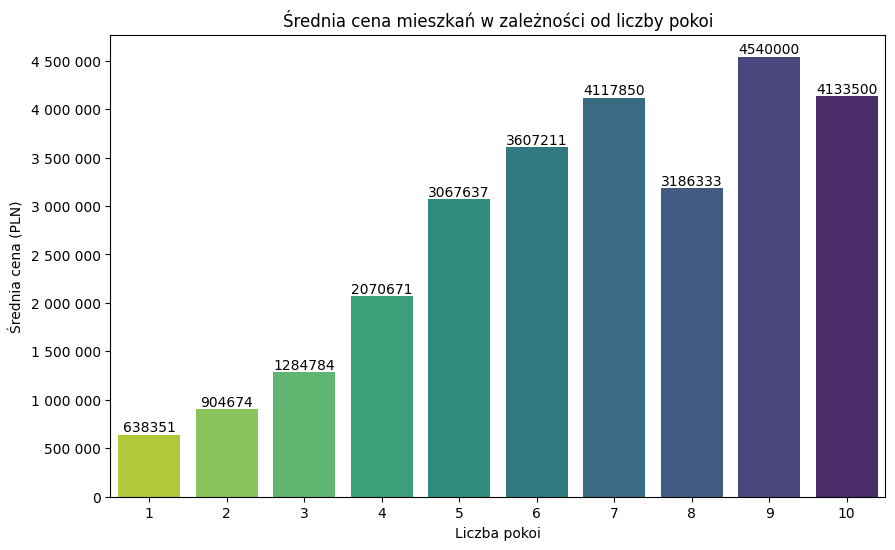

In [9]:
mean_price_rooms = df.groupby('Rooms')['Price'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_price_rooms.index, y=mean_price_rooms.values, palette='viridis_r')
plt.title('Średnia cena mieszkań w zależności od liczby pokoi')
plt.xlabel('Liczba pokoi')
plt.ylabel('Średnia cena (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500000)) 
for index, value in enumerate(mean_price_rooms.values):
    plt.text(index, value, str(int(value)), ha='center', va='bottom')
plt.show()


Na wykresie możemy wyraźnie zaobserwować, że wraz ze wzrostem liczby pokoi rośnie również średnia cena mieszkania.

Mieszkania jednopokojowe (638 351 zł) należą do najtańszych. Ich stosunkowo niewielki metraż i ograniczona funkcjonalność wpływają na niższą cenę. Stanowią one atrakcyjną opcję dla singli lub osób szukających niedrogiego lokum.

Mieszkania dwupokojowe (904 674 zł) plasują się w średniej cenie. Ich funkcjonalność i przystępny metraż sprawiają, że są one popularnym wyborem dla wielu osób. Cena za metr kwadratowy jest wyższa niż w przypadku kawalerek, ale nadal pozostaje atrakcyjna.

Mieszkania trzypokojowe (1 284 784 zł) należą do najpopularniejszych i najdroższych na rynku. Ich przestronność i funkcjonalność odpowiadają potrzebom wielu rodzin z dziećmi. Cena za metr kwadratowy jest wyższa niż w przypadku mniejszych mieszkań, ale nadal pozostaje w zasięgu możliwości wielu kupujących.

Mieszkania czteropokojowe (2 070 671 zł) oferują jeszcze więcej przestrzeni i komfortu, co przekłada się na wyższą cenę. Są one często wybierane przez rodziny z większymi dziećmi lub osoby ceniące przestronne wnętrza.

Mieszkania pięciopokojowe (3 067 637 zł) i większe (od 6 pokoi) należą do najdroższych na rynku. Ich wysoka cena wynika z dużej powierzchni, prestiżu i komfortu życia, jaki oferują. Są one często wybierane przez osoby zamożne lub prowadzące działalność gospodarczą w domu.

Możemy wyciągnąć wniosek, że wybór odpowiedniego układu pokoi powinien być podyktowany indywidualnymi potrzebami oraz budżetem. 

### Zależność metrażu od liczby pokoi

W kolejnym kroku zobaczymy jak metraż mieszkania wpływa na liczbę pomieszczeń w mieszkaniu. Statystyki te mogą być pomocne, aby oszacować czy pokoje w mieszkaniu są funkcjonalne (czy mają wystarczająco dużą powierzchnię, aby pełnić założone funkcje).

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\2779913975.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Rooms', y='m2', data=filtered_districts, palette='Set1', marker='o')


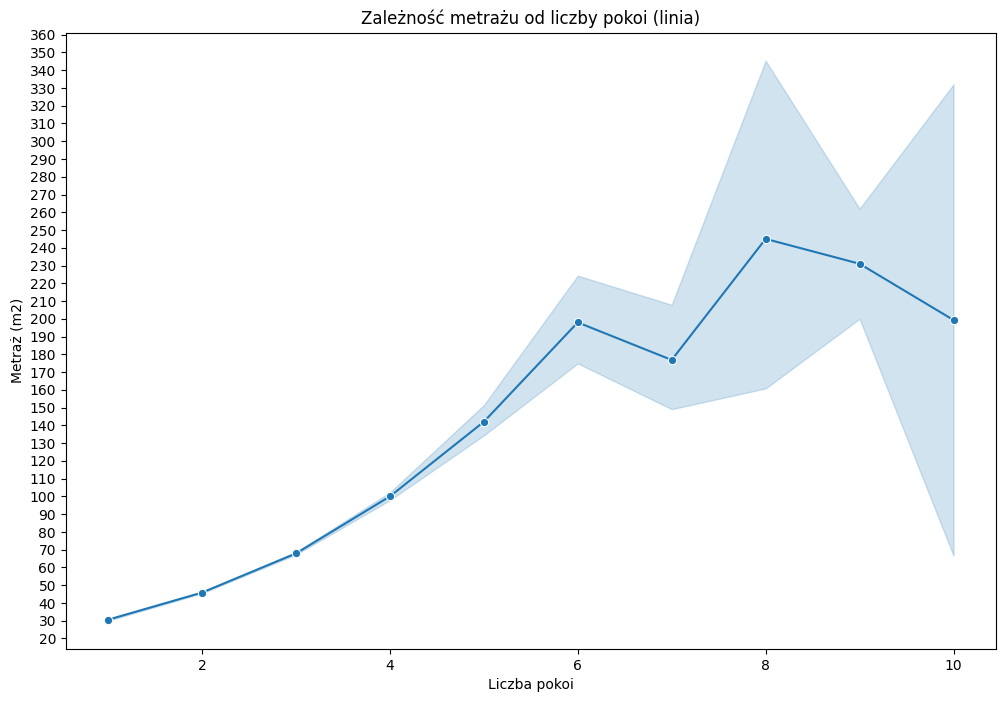

In [10]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='Rooms', y='m2', data=filtered_districts, palette='Set1', marker='o')
plt.title('Zależność metrażu od liczby pokoi (linia)')
plt.xlabel('Liczba pokoi')
plt.ylabel('Metraż (m2)')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()


Mieszkania jednopokojowe średnio mają 31 m2, dwupokojowe 49 m2, trzypokojowe mieszkania o średniej powierzchnii 71 m2 należą do najpopularniejszych i najbardziej funkcjonalnych układów. 
Mieszkania czteropokojowe zajmują średnio 102 m2 i większe (od 5 pokoi) oferują jeszcze więcej przestrzeni i komfortu. Ich średnia powierzchnia waha się od 102 m2 do 255 m2, w zależności od liczby pokoi. 

### Zależność metrażu od liczby pokoi w poszczególnych dzielnicach

Następnie połączymy analizę liczby pokoi względem metrażu z podziałem na dzielnice. Taka analiza pozwala rozeznać się w jakich dzielnicach pokoje standardowo są robione mniejsze, a w jakich większe (np. kuchnia otwarta łączona z salonem).

In [74]:
import plotly.express as px

fig = make_subplots(rows=5, cols=5, subplot_titles=df['District'].unique())

row = 1
col = 1
for i, district in enumerate(df['District'].unique()):
    district_data = df[df['District'] == district]
    scatter_plot = px.scatter(district_data, x='m2', y='Rooms', color_continuous_scale=px.colors.sequential.Viridis)
    scatter_plot.update_traces(marker=dict(color=i))  
    fig.add_trace(scatter_plot.data[0], row=row, col=col)
    fig.update_xaxes(title_text="Metraż [m2]", row=row, col=col)
    fig.update_yaxes(title_text="Liczba pokoi", row=row, col=col) 
    col += 1
    if col > 5:
        col = 1
        row += 1

fig.update_layout(height=1200, width=1200, title_text="Metraż mieszkania a liczba pokoi w zależności od dzielnicy")
fig.show()


Wykres przedstawia szczegółowe informacje na temat rozkładu metrażu mieszkań w poszczególnych kategoriach pokoi z podziałem na dzielnice Warszawy.

Analiza danych pozwala na wyciągnięcie kilku interesujących wniosków:

W przypadku kawalerek (1 pokój) średni metraż waha się od 12 m2 (Śródmieście) do 35 m2 (Wesoła). Różnica ta wynika z charakteru dzielnic - Wesoła to głównie przedmieścia z nowym budownictwem, gdzie kawalerki są zazwyczaj większe, podczas gdy na Śródmieściu w części mieszkalnej dominuje starsza zabudowa z mniejszymi mieszkaniami.
Podobne zależności można zaobserwować w przypadku innych kategorii pokoi. Mieszkania w Wilanowie i Mokotowie charakteryzują się średnio większym metrażem niż w takich dzielnicach jak Białołęka czy Rembertów.
Szczególnie widoczne są różnice w przypadku mieszkań 5-pokojowych. W Śródmieściu ich średni metraż sięga nawet 260 m2, podczas gdy we Włochach wynosi on 135 m2.
Zróżnicowanie w układach pokoi:

W niektórych dzielnicach, takich jak Żoliborz czy Ursynów, brakuje danych dla niektórych kategorii pokoi (np. 5-pokojowych na Ursusie). Oznacza to, że układy te są tam rzadsze.
W innych dzielnicach, np. na Białołęce czy Targówku, rozkład metrażu jest bardziej równomierny we wszystkich kategoriach pokoi. Oznacza to, że można tam znaleźć mieszkania o różnych układach pokoi w zbliżonym metrażu.

Analizując wykres zauważamy, że na metraż i układ pokoi wpływa również lokalizacja mieszkania w danej dzielnicy. Mieszkania położone w centrum lub w prestiżowych okolicach zazwyczaj są droższe i mają większy metraż niż te na obrzeżach.

### Zależność metrażu od liczby pokoi z uwzględnieniem ceny

Tym razem rozszerzymy analizę o cenę. Spójrzmy na zależność metrażu od liczby pokoi z uwzględnieniem ceny. Wykres ten pokaże nam, jak cena i metraż zmieniają się w zależności od liczby pokoi w mieszkaniu. Pomoże to w identyfikacji ofert o optymalnym stosunku ceny do powierzchni lokalu i liczby pokoi.

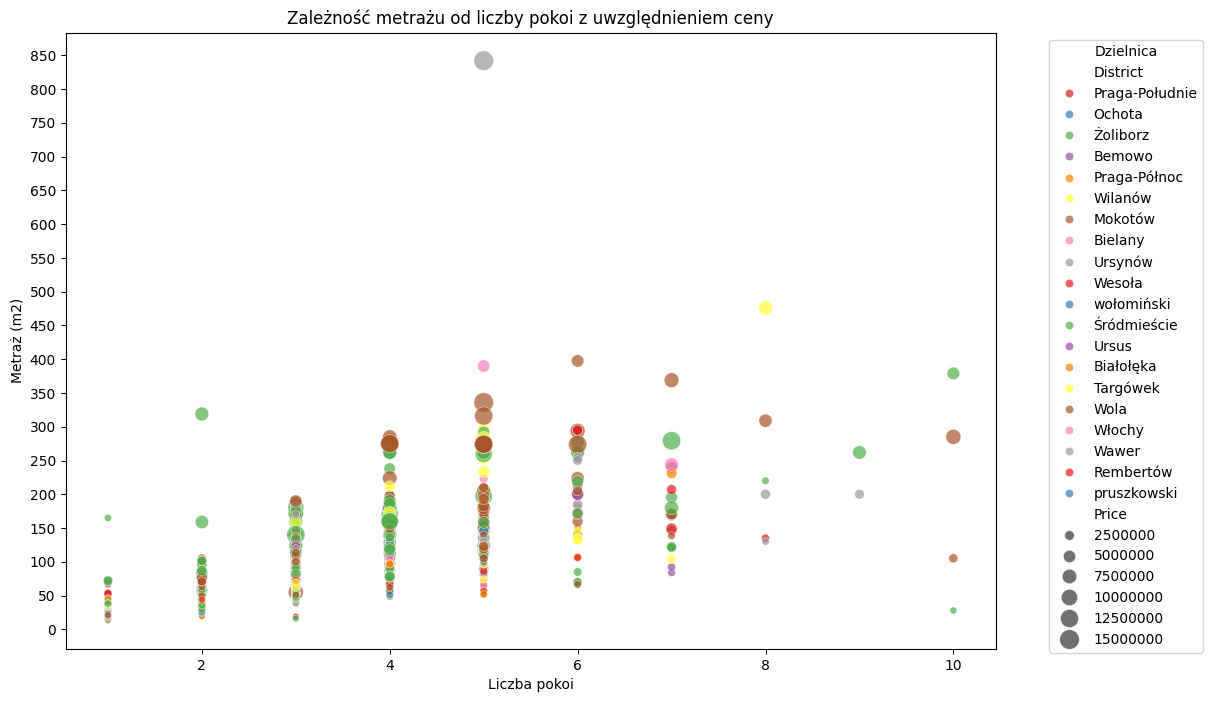

In [72]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Rooms', y='m2', data=filtered_districts, hue='District', palette='Set1', alpha=0.7, size='Price', sizes=(20, 200))
plt.title('Zależność metrażu od liczby pokoi z uwzględnieniem ceny')
plt.xlabel('Liczba pokoi')
plt.ylabel('Metraż (m2)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
plt.show()


### Zależność liczby pokoi od ceny mieszkania

Spójrzmy jeszcze jaki związek ma ilość pokoi z ceną mieszkania.

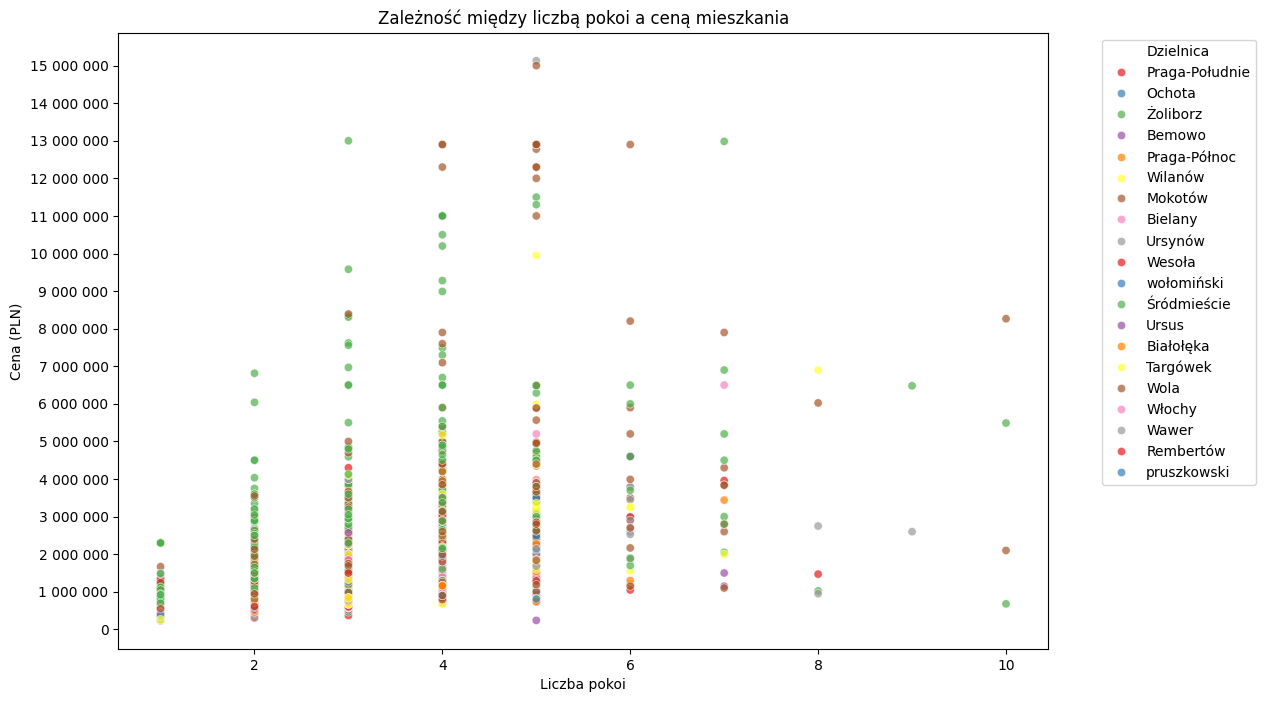

In [12]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Rooms', y='Price', data=filtered_districts, hue='District', palette='Set1', alpha=0.7)
plt.title('Zależność między liczbą pokoi a ceną mieszkania')
plt.xlabel('Liczba pokoi')
plt.ylabel('Cena (PLN)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1000000))
plt.show()

### Liczba ofert w poszczególnych dzielnicach

Na koniec przyjrzymy się liczbie ofert w poszczególnych dzielnicach. Taka analiza pokaże nam, w jakich lokalizacjach dostępnych jest najwięcej, a w jakich najmniej ofert. Informacje te mogą być pomocne w wyborze dzielnicy, w której łatwiej będzie znaleźć mieszkanie spełniające oczekiwania klienta.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_5788\479042829.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')


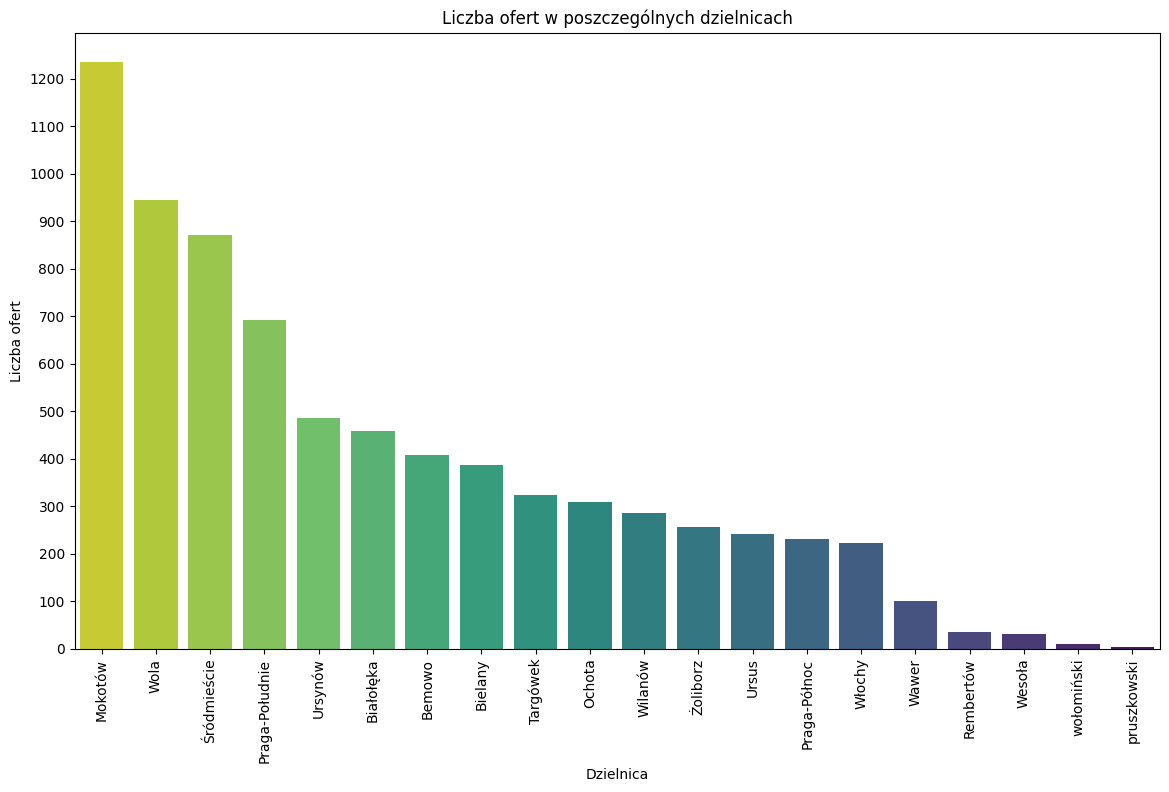

In [13]:
plt.figure(figsize=(14, 8))
sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')
plt.title('Liczba ofert w poszczególnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
plt.show()


Najwięcej ofert jest dostępnych w Mokotowie (1235), na Woli (944) i w Śródmieściu (870). Dzielnice te charakteryzują się bliską odległością od centrum oraz rozbudowanym transportem publicznym, co powoduje, że cieszą sie dużą popularnością wśród kupujących, a to z kolei przekłada się na wyższą liczbę ofert.

Dużą liczbę ofert można również znaleźć na Pradze-Południe (691), Ursynowie (486) i Białołęce (458). Dzielnice te oferują szeroki wybór mieszkań w różnych przedziałach cenowych, co czyni je atrakcyjnymi dla wielu osób.

Mniejszą liczbę ofert odnotowano w Bemowie (407), na Bielanach (386), Targówku (324) i na Ochocie (308). Dzielnice te nadal cieszą się zainteresowaniem kupujących, ale oferta jest tam nieco mniejsza.

Jeszcze mniej ofert jest dostępnych w Wilanowie (286), na Żoliborzu (256), Ursusie (242), na Pradze-Północ (230) i we Włochach (222). Dzielnice te są często wybierane przez osoby szukające prestiżowych lokalizacji lub większych mieszkań, co przekłada się na niższą liczbę ofert dostępnych na rynku.

Najmniej ofert można znaleźć w lokalizacjach najbardziej oddalonych od centrum czyli w Wawrze (100), Rembertowie (36) i Wesołej (30). Dzielnice te położone są na obrzeżach Warszawy i oferują głównie domy jednorodzinne.

I tradycyjnie w powiatach wołomińskim (9) i pruszkowskim (3) liczba ofert jest najmniesza, ponieważ większość osób szukających mieszkań w tym rejonie woli kupować je w granicach Warszawy.